### Objective

- The goal of this project is to use a bunch of news articles extracted from the companies’ internal database and categorize them into several categories like politics, technology, sports, business and entertainment based on their content. Use natural language processing and create & compare at least three different models.

In [92]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly_express as px
import nltk
                            
from nltk.corpus import twitter_samples    
from nltk.corpus import stopwords         
from nltk.stem import PorterStemmer        
from nltk.stem import WordNetLemmatizer   
from nltk.tokenize import TweetTokenizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,precision_score, recall_score
import warnings

warnings.filterwarnings('ignore')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\revan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\revan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [93]:
df = pd.read_csv("flipitnews-data.csv")

In [94]:
fig = px.pie(df, names='Category',hole=0.3, title='Category Pie Chart')
fig.show()

Labels in the dataset:  ['Technology' 'Business' 'Sports' 'Entertainment' 'Politics']
Category
Sports           511
Business         510
Politics         417
Technology       401
Entertainment    386
Name: count, dtype: int64


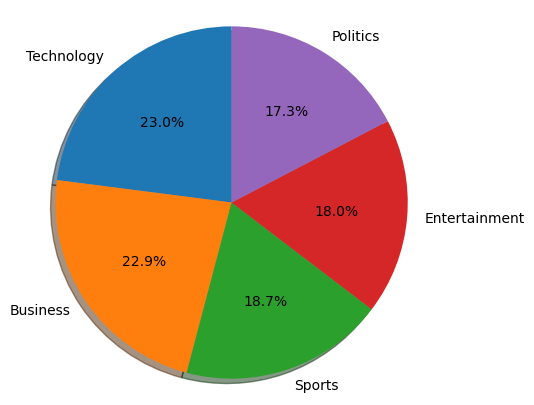

In [95]:
def pie_chart(dataframe):
  # Converting pd object to list of string
  label_types  = dataframe.Category.unique().astype(str) 
  # Count tweets for each label
  label_counts = dataframe.Category.value_counts()     
  print('Labels in the dataset: ', label_types) 
  print(label_counts)             
  # labels for the two classes
  labels = label_types #'Positives', 'Negative'
  # Sizes for each slide
  sizes = [count for count in label_counts]
  # Declare a figure with a custom size
  fig = plt.figure(figsize=(5, 5))
  # Declare pie chart, where the slices will be ordered and plotted counter-clockwise:
  plt.pie(sizes, labels=labels, autopct='%1.1f%%',
          shadow=True, startangle=90)
  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.axis('equal') 
  # Display the chart
  plt.show()

pie_chart(df)

### User defined function to process the textual data

In [96]:
def process_tweet(tweet):
    lemmatizer = WordNetLemmatizer()
    stopwords_english = stopwords.words('english')
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks    
    tweet = re.sub(r'https?://[^\s\n\r]+', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # tokenize tweets
    tweet = re.sub(r'[0-9]+', '', tweet)
    # tokenize tweets
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    tweets_clean = []
    for word in tweet_tokens:
        if (word not in stopwords_english and  # remove stopwords
                word not in string.punctuation):  # remove punctuation
            # tweets_clean.append(word)
            lemma_word = lemmatizer.lemmatize(word)  # stemming word
            tweets_clean.append(lemma_word)
    
    word1 = ""
    for i in tweets_clean:
        word1+= i +" "

    return word1

In [97]:
df["Cleaned_Text"] = df["Article"].apply(process_tweet)

In [98]:
print("Before Preprocess")
print(df["Article"][100])
print("-"*200)
print("After Preprocess")
print(df["Cleaned_Text"][100])


Before Preprocess
housewives lift channel 4 ratings the debut of us television hit desperate housewives has helped lift channel 4 s january audience share by 12% compared to last year.  other successes such as celebrity big brother and the simpsons have enabled the broadcaster to surpass bbc two for the first month since last july. bbc two s share of the audience fell from 11.2% to 9.6% last month in comparison with january 2004. celebrity big brother attracted fewer viewers than its 2002 series.  comedy drama desperate housewives managed to pull in five million viewers at one point during its run to date  attracting a quarter of the television audience. the two main television channels  bbc1 and itv1  have both seen their monthly audience share decline in a year on year comparison for january  while five s proportion remained the same at a slender 6.3%. digital multi-channel tv is continuing to be the strongest area of growth  with the bbc reporting freeview box ownership of five mill

### Bag of Words and TF-IDF techniques for vectorizing the data

In [99]:
def Text_to_matrix(df,choice):
    cv = CountVectorizer()
    # Learn the vocabulary dictionary and return document-term matrix
    bow_rep = cv.fit_transform(df["Cleaned_Text"]).todense()  #
    bow_dataframe = pd.DataFrame(bow_rep)
    # Get output feature names for dataframe columns.
    bow_dataframe.columns = cv.get_feature_names()
    bow_dataframe["Category"] = df["Category"]

    tfidf_vectorizer = TfidfVectorizer(min_df=5)
    # min_df: ignore terms that have a document frequency strictly lower than the given threshold.
    tfidf_features = tfidf_vectorizer.fit_transform(df["Cleaned_Text"]).todense()  # todense() returns a matrix
    # create dataframe
    tfidf_features_df = pd.DataFrame(tfidf_features)
    tfidf_features_df.columns = tfidf_vectorizer.get_feature_names()  # Get output feature names for dataframe columns.
    tfidf_features_df["Category"] = df["Category"]
    if choice == "tf":
        return tfidf_features_df
    elif choice == "bow":
        return bow_dataframe 

In [100]:
tf_idf_df = Text_to_matrix(df,choice="tf")

###  Train-test split and train a Naive Bayes classifier model using the simple/classical approach.

In [101]:
x = tf_idf_df.drop("Category",axis=1)
y = tf_idf_df["Category"]

In [102]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2)

In [103]:
print(xtrain.shape,xtest.shape,ytrain.shape,ytest.shape)

(1780, 8017) (445, 8017) (1780,) (445,)


In [104]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
ytrain = le.fit_transform(ytrain)
ytest = le.transform(ytest)

In [105]:
model = MultinomialNB()
model.fit(xtrain,ytrain)

MultinomialNB()

### Evaluate the model’s performance and plot the Confusion Matrix as well as Classification Report.

Classification report:               precision    recall  f1-score   support

           0       0.98      0.93      0.96       107
           1       1.00      0.93      0.97        89
           2       0.93      0.98      0.96        88
           3       1.00      1.00      1.00        91
           4       0.91      1.00      0.95        70

    accuracy                           0.97       445
   macro avg       0.96      0.97      0.97       445
weighted avg       0.97      0.97      0.97       445



Text(113.9222222222222, 0.5, 'predicted label')

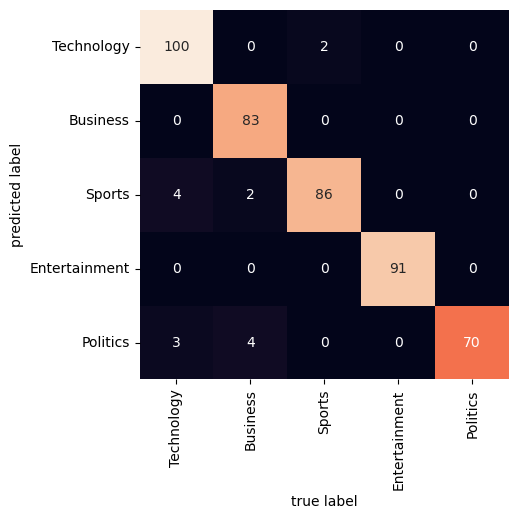

In [106]:
labels = model.predict(xtest)
mat = confusion_matrix(ytest, labels)
print(f"Classification report: {classification_report(ytest, labels)}")
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=df["Category"].unique(), yticklabels=df["Category"].unique())
plt.xlabel('true label')
plt.ylabel('predicted label')

### Evaluate three more classifier models (Decision Tree, Nearest Neighbors, Random Forest)

In [107]:
dtc = DecisionTreeClassifier()
dtc_params = {'max_depth': [2, 4, 6]}
dtc_grid = GridSearchCV(dtc, dtc_params)
dtc_grid.fit(xtrain, ytrain)
dtc_score = dtc_grid.score(xtest, ytest)

# K-Nearest Neighbors Classifier
knn = KNeighborsClassifier()
knn_params = {'n_neighbors': [3, 5, 7]}
knn_grid = GridSearchCV(knn, knn_params)
knn_grid.fit(xtrain, ytrain)
knn_score = knn_grid.score(xtest, ytest)

# Random Forest Classifier
rfc = RandomForestClassifier()
rfc_params = {'n_estimators': [100, 200], 'max_depth': [2, 4]}
rfc_grid = GridSearchCV(rfc, rfc_params)
rfc_grid.fit(xtrain, ytrain)
rfc_score = rfc_grid.score(xtest, ytest)

print({'Decision Tree': dtc_score,
            'K-Nearest Neighbors': knn_score,
            'Random Forest': rfc_score})

{'Decision Tree': 0.6764044943820224, 'K-Nearest Neighbors': 0.9370786516853933, 'Random Forest': 0.8426966292134831}


Classification report:               precision    recall  f1-score   support

           0       0.80      0.79      0.80       107
           1       0.93      0.43      0.58        89
           2       0.93      0.49      0.64        88
           3       0.43      0.97      0.60        91
           4       0.96      0.67      0.79        70

    accuracy                           0.68       445
   macro avg       0.81      0.67      0.68       445
weighted avg       0.80      0.68      0.68       445



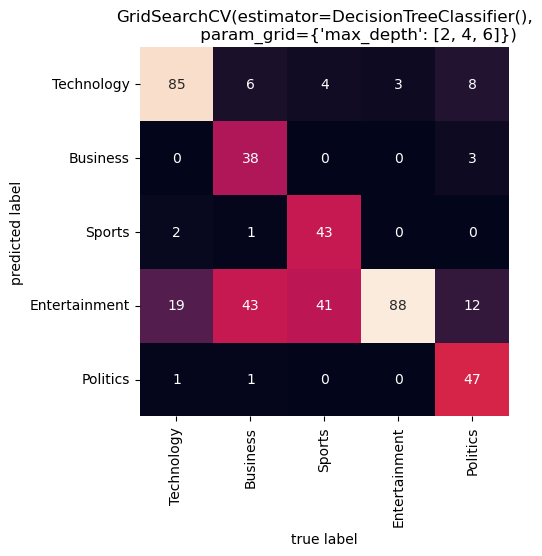

Classification report:               precision    recall  f1-score   support

           0       0.96      0.89      0.92       107
           1       0.99      0.89      0.93        89
           2       0.87      0.94      0.91        88
           3       0.99      0.99      0.99        91
           4       0.88      1.00      0.93        70

    accuracy                           0.94       445
   macro avg       0.94      0.94      0.94       445
weighted avg       0.94      0.94      0.94       445



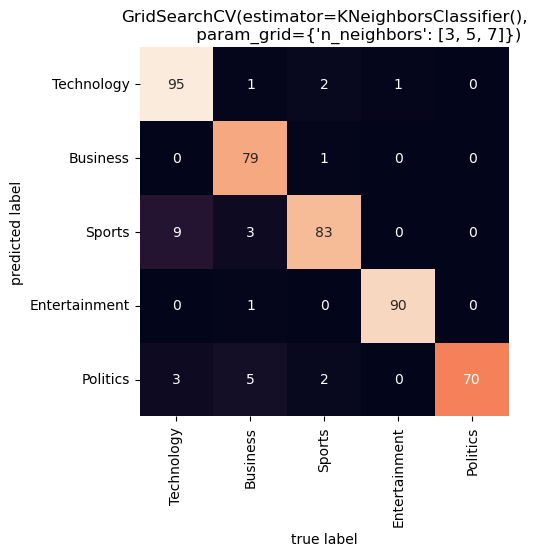

Classification report:               precision    recall  f1-score   support

           0       0.78      0.95      0.86       107
           1       1.00      0.54      0.70        89
           2       0.97      0.82      0.89        88
           3       0.72      1.00      0.83        91
           4       0.95      0.89      0.92        70

    accuracy                           0.84       445
   macro avg       0.88      0.84      0.84       445
weighted avg       0.88      0.84      0.84       445



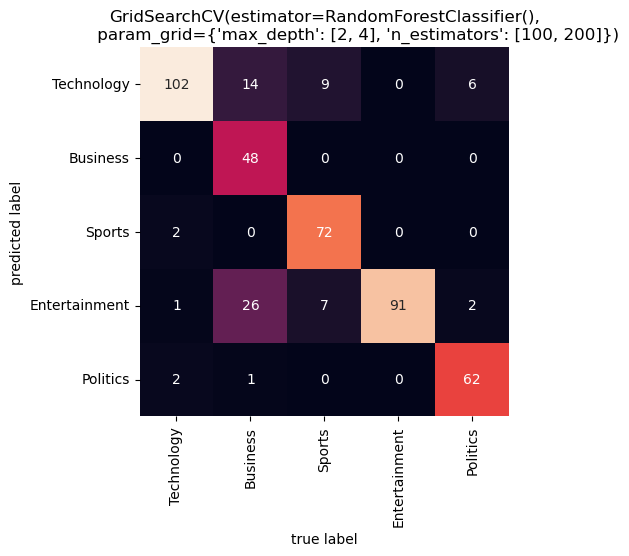

In [111]:
models = [dtc_grid,knn_grid,rfc_grid]
for model in models:
    labels = model.predict(xtest)
    mat = confusion_matrix(ytest, labels)
    print(f"Classification report: {classification_report(ytest, labels)}")
    plt.title(f"{model}")
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=df["Category"].unique(), yticklabels=df["Category"].unique())
    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()
    

### Observe and comment on the performances of all the models used

In [109]:
# Naive bayes model is performing well when compared to other models
# We are clustering groups based on the input features, the clustering algorithms are doing better compared to other trees algorithm
# Thats why Naive bayes and Knn algorithm did their jobs better